**Load the required libraries and datasets**

In [1]:
# Libraries
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns 

In [2]:
# Data
## Successfull appointment data 
seen_df = pd.read_csv("../data/exports/successfull-appointments.csv")

## Post intake data 
df = pd.read_csv("../data/exports/post-intake.csv")
df.head()

,Chartnumber,First post-enrollment service,First post-intake service,Post-intake days,Days btn MHinfusion and Intake,Visits,MH infusions,infusions outside Cambridge,Visits outside Cambridge,Intake Facility City,Patient category
0,1,Intake,TMS,14.0,NaN,49,0,0,0,CAMBRIDGE,before mid-2023
1,2,MH Infusion,NaN,NaN,NaN,8,8,0,0,CAMBRIDGE,before mid-2023
2,9,Intake,TMS,9.0,66.0,68,30,0,0,CAMBRIDGE,before mid-2023
3,6,Intake,MH Infusion,0.0,0.0,16,13,0,0,CAMBRIDGE,before mid-2023
4,12,Intake,NaN,NaN,NaN,1,0,0,0,CAMBRIDGE,before mid-2023


In [3]:
# Convert appointment date to datetime 
seen_df["Date"] = pd.to_datetime(seen_df["Date"])

# Order the dataset by date 
seen_df = seen_df.sort_values(by="Date", ascending=True)
seen_df.reset_index(drop=True, inplace=True)

# Data analysis 

In [4]:
def remove_outliers(df, variable):
    """
    Docstring
    This function will remove the outliers from the variable in the data set
    - Uses the IQR method 
    """
    # Calculate Q1, Q3, and IQR
    Q1 = df[variable].quantile(0.25)  # 25th percentile
    Q3 = df[variable].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter data to remove outliers
    df_no_outliers = df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)]

    return df_no_outliers

## Step 1: Formulate and Test Hypotheses
Here are some potential areas to investigate:

**Post-Intake Service Delays:**

- *Hypothesis:* Longer delays in receiving the first post-intake service could lead to fewer MH infusions.
- *Visualization Idea:* Boxplot or histogram showing Post-intake days by Intake Facility City and Patient Category.

**Service Accessibility:**

- *Hypothesis:* Patients requiring MH infusions outside Cambridge may have been impacted by logistical challenges or resource limitations.
- *Visualization Idea:* Bar chart comparing the count of Infusions outside Cambridge and Visits outside Cambridge across patient categories.

**Visit Patterns:**

- *Hypothesis:* A decline in Number of Visits correlates with fewer MH infusions.
- *Visualization Idea:* Scatterplot with Number of Visits on the x-axis and Number of MH infusions on the y-axis, color-coded by Intake Facility City.

**Intake-to-Infusion Time:**

- *Hypothesis:* Longer gaps between intake and the first MH infusion discourage subsequent infusions.
- *Visualization Idea:* Line plot showing the average Days btn MHinfusion and Intake over time (by patient category).

<Axes: xlabel='Patient category', ylabel='Post-intake days'>

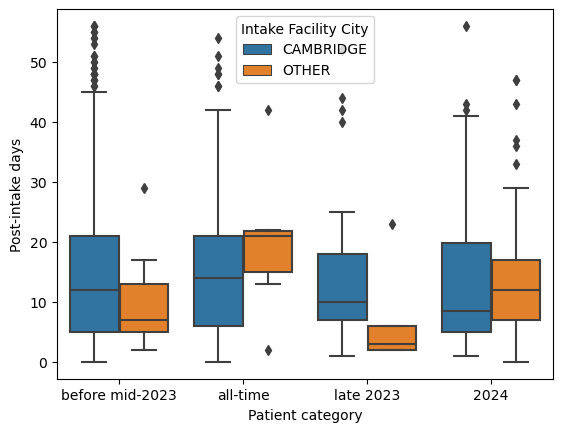

In [5]:
# Post-intake Service Delays
## Select the required columns 
selected_columns = ["Patient category", "Post-intake days", "Intake Facility City"]
select_df = df[selected_columns]

## Remove outliers
select_df = remove_outliers(select_df, "Post-intake days")

## Plotting 
sns.boxplot(x="Patient category", y="Post-intake days", 
            hue="Intake Facility City", data=select_df)

<Axes: xlabel='Patient category', ylabel='Days btn MHinfusion and Intake'>

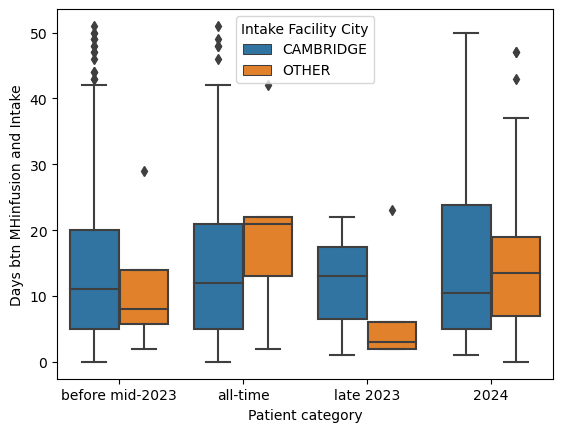

In [6]:
# Post-intake Service Delays
## Select the required columns 
selected_columns = ["Patient category", "Days btn MHinfusion and Intake", "Intake Facility City"]
select_df = df[selected_columns]

## Remove outliers
select_df = remove_outliers(select_df, "Days btn MHinfusion and Intake")

## Plotting 
sns.boxplot(x="Patient category", y="Days btn MHinfusion and Intake", 
            hue="Intake Facility City", data=select_df)

- Patients that had intake from Cambridge had to wait relatively longer to get their first service after intake compared to facilities in other cities
- Patients who joined in 2024 waited longer to have their first MH infusion than all time patients and the ones before mid 2023. 
- Patients in late 2023 waited the least. It is practically imposible for them to have longer waiting period since they are the segments that had their first and last service in a span of 6 months (From beginning of July to the end-year). 

In [7]:
cambridge_df = df[df["Intake Facility City"]=="CAMBRIDGE"]

cambridge_df["First post-intake service"].value_counts()/len(cambridge_df)

First post-intake service
MH Infusion        0.545455
TMS                0.120210
Follow-Up          0.039820
KAP Integration    0.019534
Med Management     0.006762
Intake             0.004508
Misc.              0.003757
KAP Infusion       0.002254
KSS                0.000751
Name: count, dtype: float64

In [8]:
other_df = df[df["Intake Facility City"]!="CAMBRIDGE"]

other_df["First post-intake service"].value_counts()/len(other_df)

First post-intake service
MH Infusion        0.437956
TMS                0.029197
KAP Integration    0.029197
Follow-Up          0.014599
Pain Infusion      0.007299
Name: count, dtype: float64

In [9]:
df["First post-intake service"].isna().sum()

408

## <span style="color: orange;">**Bonus Idea**</span>

What if I check the span(days) between successive appointments over time? 

*Hypothesis*: Patients are made to wait more in Cambridge for their next appointment. That is the cause of the drop of MH infusions. 

I wanna analyze get the date of the most recent visit and MH infusion over time. Line chart for Cambridge and facilities in other cities to see how it compares with other cities its changes over time

In [10]:
# Will be required to have the appointment data 

**Blueprint**

Columns required; 

- date of service, 
- facility city 
- Appointment Type group
- Chart number

All appointments must be successfull("Seen") 

How I will get this done; 

* Get the successfull appointment data 
* Loop through every record
* If record is intake just "pass" record zero otherwise use the chart number to backcheck its recent appointment
    - Backchecking will be done by slicing the data set till the current index(one row behind)
    - Filter to get the very chart number
    - Check the date of the last service 
    - Calculate the difference in days 
    
* Add the day difference to a list


**Repeat the same for MH infusion**

Columns to added - "days since last visit" and "days since last MH infusion" 

In [12]:
# Days since last visit
days_since_last_visit = []
delay_for_MHinfusion = []

for index_number in seen_df.index:
    # Note the chart number and the current date
    current_date = seen_df.iloc[index_number]["Date"]
    chart_number = seen_df.iloc[index_number]["Chartnumber"]
    service_type = seen_df.iloc[index_number]["Appt Type Group"] 

    if index_number == 0: # No past records 
        days_since_last_visit.append(np.nan) # add a null point 
        delay_for_MHinfusion.append(np.nan)

    else: # Posibility of past records for the patient 
        # select all the records before it
        records_before = seen_df.iloc[0:index_number] # add null point 
        
        # Select the records before specifically for the patient 
        patients_records_before = records_before[records_before["Chartnumber"]==chart_number]\
        .reset_index(drop=True)
        
        # if no past records
        if patients_records_before.shape[0]==0:
            days_since_last_visit.append(np.nan)
            delay_for_MHinfusion.append(np.nan)

        else: # past records exists
            
            # Select the last_record
            last_record = patients_records_before.to_records()[-1]
            # Note the last date 
            last_date = pd.Timestamp(last_record[1])

            delay_days = (current_date - last_date).days
            days_since_last_visit.append(delay_days) # Add the delay days
            
            # Check for MH infusion delays 
            if service_type == 'MH Infusion':
                delay_for_MHinfusion.append(delay_days)
            else:
                delay_for_MHinfusion.append(np.nan)
            
            

In [15]:
# add to the dataframe
seen_df["Days since last visit"] = days_since_last_visit
seen_df["Delay for MH infusion"] = delay_for_MHinfusion

<Axes: xlabel='Date'>

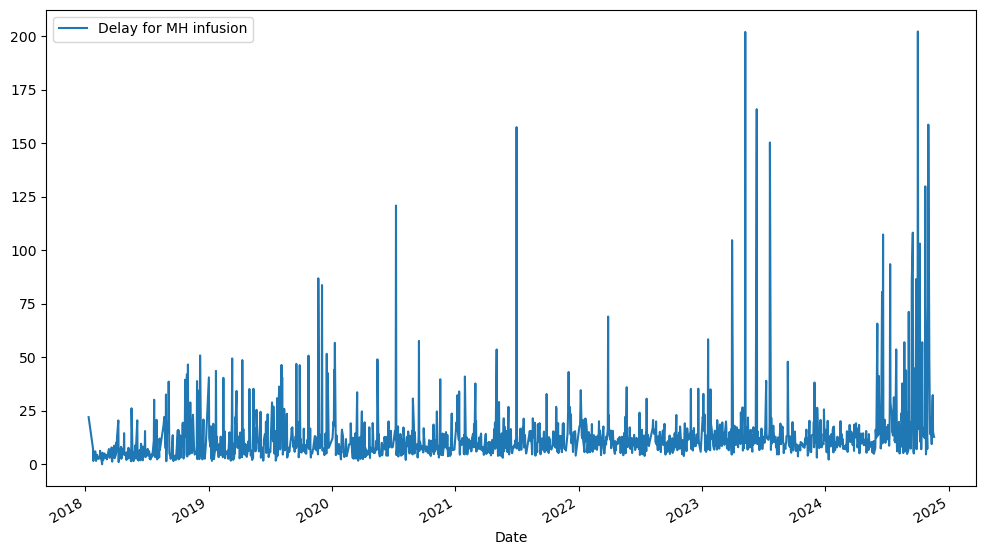

In [52]:
# Plot a line chart for MH infusion
MHinfusion_delays_df = seen_df[["Date", "Delay for MH infusion"]].groupby("Date").mean()
MHinfusion_delays_df.dropna(how="any", inplace=True) # Drop null records

MHinfusion_delays_df.plot(figsize=(12, 7))

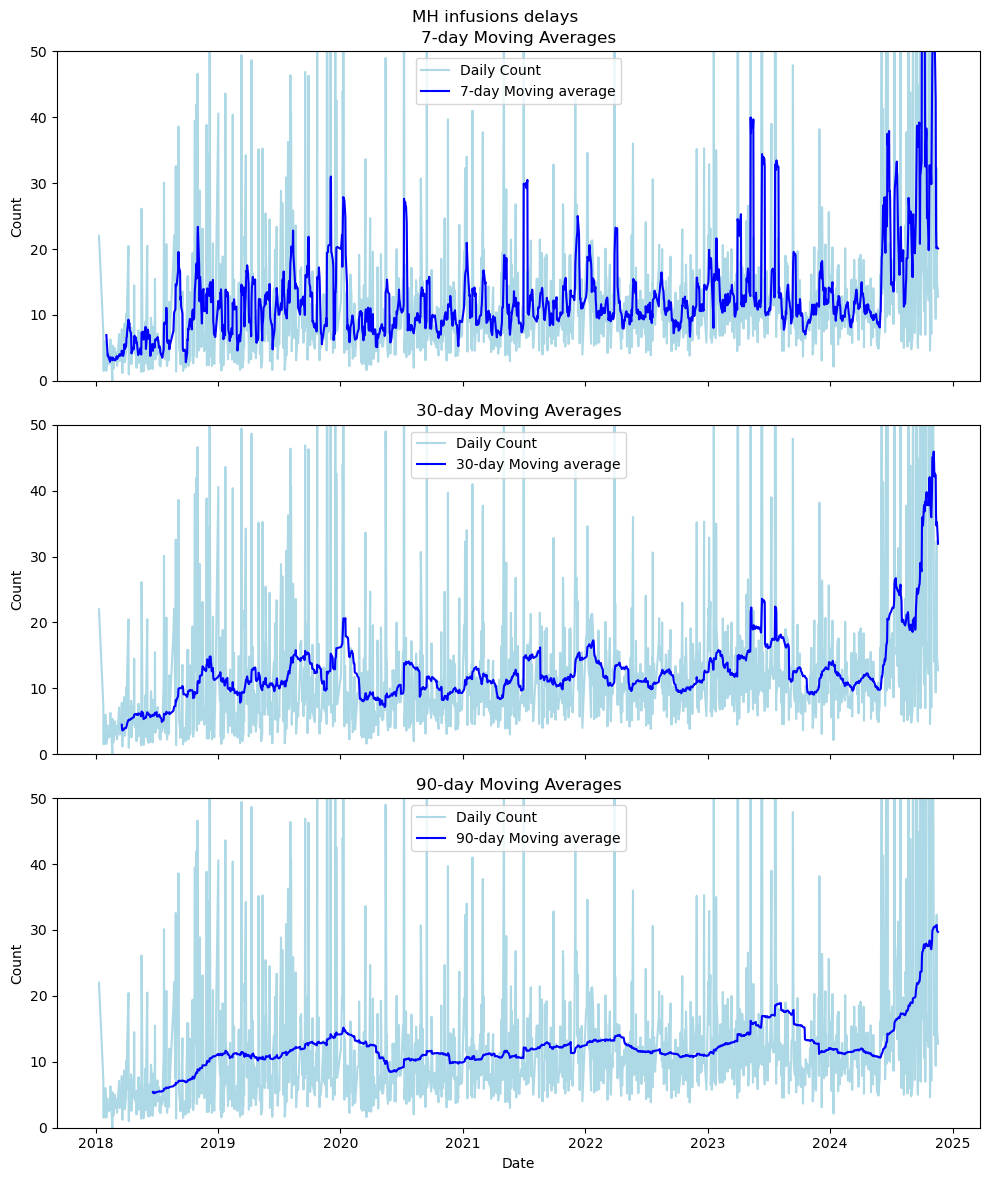

In [53]:
# Create subplots  
fig, axes = plt.subplots(nrows=3, ncols=1,
                        figsize=(10, 12), sharex=True)

# 7-day Moving average plot 
MHinfusion_delays_df["7_day_MA"] = MHinfusion_delays_df["Delay for MH infusion"].rolling(window=7).mean()
## Plotting
axes[0].plot(MHinfusion_delays_df.index, MHinfusion_delays_df["Delay for MH infusion"],
        label = "Daily Count", color="lightblue")
axes[0].plot(MHinfusion_delays_df.index, MHinfusion_delays_df["7_day_MA"],
        label = "7-day Moving average", color="blue")
axes[0].set_ylabel("Count")

axes[0].set_title("7-day Moving Averages")
axes[0].legend()
axes[0].set_ylim(0, 50)

# 30-day Moving average plot 
MHinfusion_delays_df["30_day_MA"] = MHinfusion_delays_df["Delay for MH infusion"].rolling(window=30).mean()
## Plotting
axes[1].plot(MHinfusion_delays_df.index, MHinfusion_delays_df["Delay for MH infusion"],
        label = "Daily Count", color="lightblue")
axes[1].plot(MHinfusion_delays_df.index, MHinfusion_delays_df["30_day_MA"],
        label = "30-day Moving average", color="blue")
axes[1].set_ylabel("Count")

axes[1].set_title("30-day Moving Averages")
axes[1].legend()
axes[1].set_ylim(0, 50)

# 90-day Moving average plot 
MHinfusion_delays_df["90_day_MA"] = MHinfusion_delays_df["Delay for MH infusion"].rolling(window=90).mean()
## Plotting
axes[2].plot(MHinfusion_delays_df.index, MHinfusion_delays_df["Delay for MH infusion"],
        label = "Daily Count", color="lightblue")
axes[2].plot(MHinfusion_delays_df.index, MHinfusion_delays_df["90_day_MA"],
        label = "90-day Moving average", color="blue")
axes[2].set_ylabel("Count")

axes[2].set_title("90-day Moving Averages")
axes[2].legend()
axes[2].set_ylim(0, 50)

plt.suptitle("MH infusions delays")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

<Axes: xlabel='Date'>

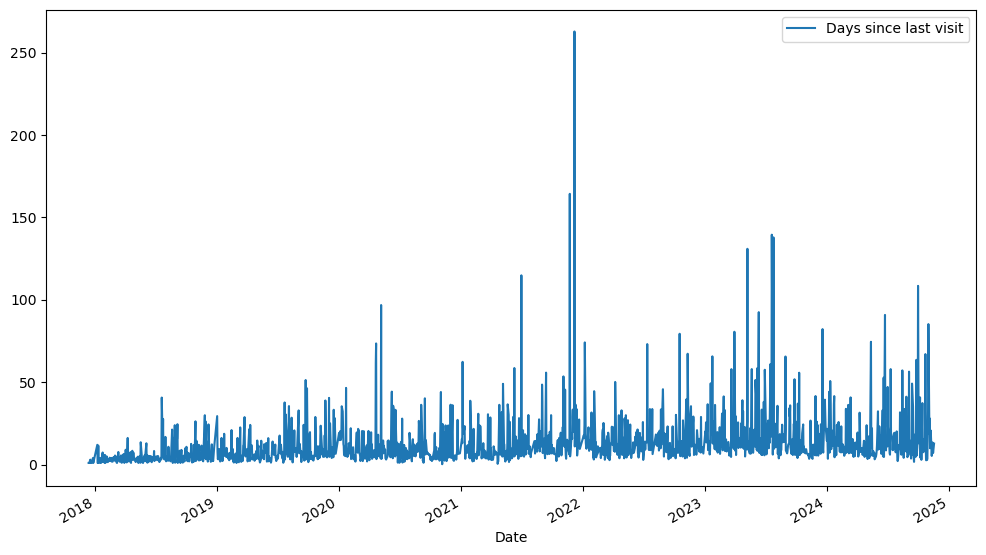

In [45]:
# Days since last visit exclusive data 

# Plot a line chart for MH infusion
last_visit_df = seen_df[["Date", "Days since last visit"]].groupby("Date").mean()
last_visit_df.dropna(how="any", inplace=True) # Drop null records

last_visit_df.plot(figsize=(12, 7))

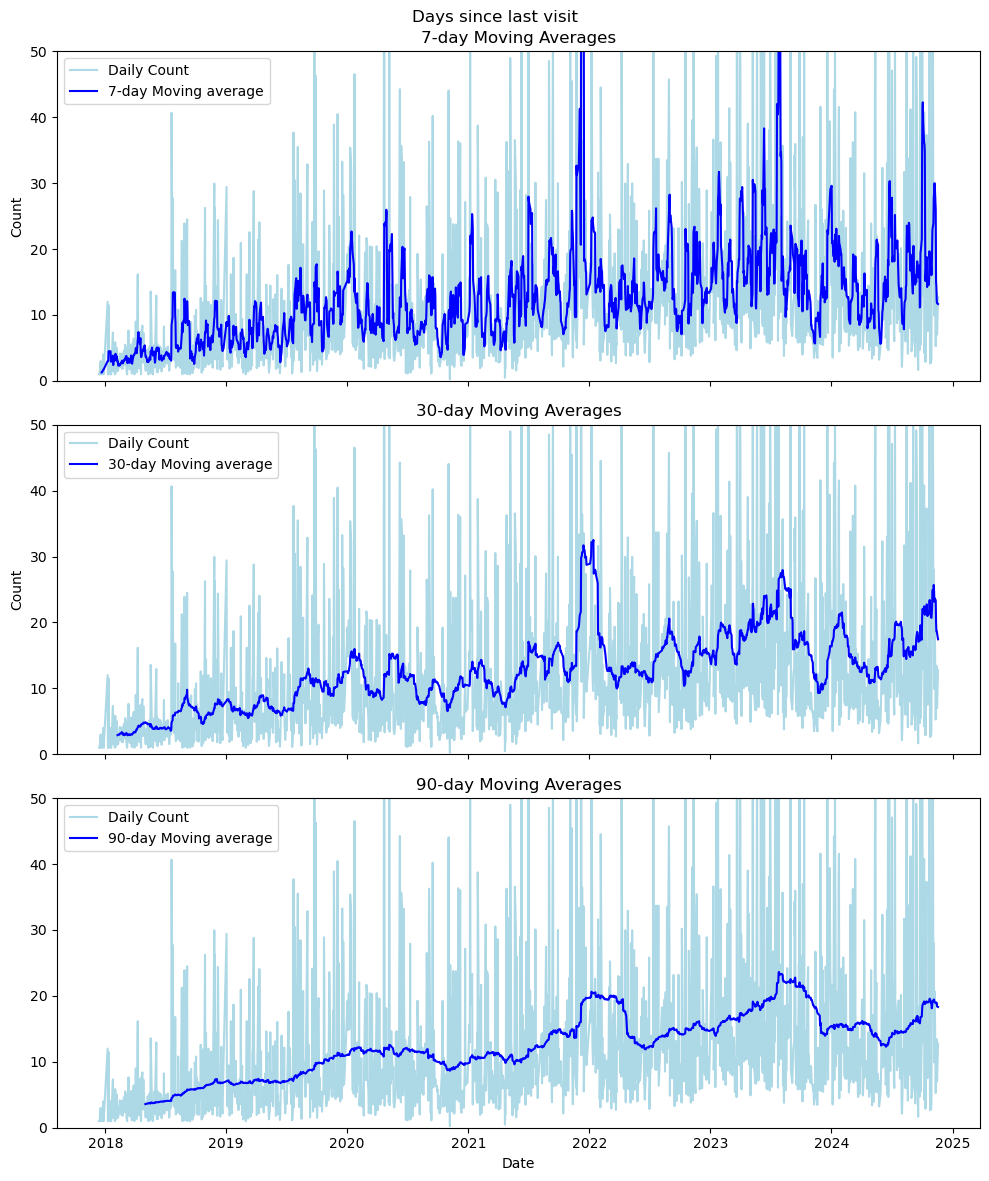

In [51]:
# Plot a line for days since last visit
# Create subplots  
fig, axes = plt.subplots(nrows=3, ncols=1,
                        figsize=(10, 12), sharex=True)

# 7-day Moving average plot 
last_visit_df["7_day_MA"] = last_visit_df["Days since last visit"].rolling(window=7).mean()
## Plotting
axes[0].plot(last_visit_df.index, last_visit_df["Days since last visit"],
        label = "Daily Count", color="lightblue")
axes[0].plot(last_visit_df.index, last_visit_df["7_day_MA"],
        label = "7-day Moving average", color="blue")
axes[0].set_ylabel("Count")

axes[0].set_title("7-day Moving Averages")
axes[0].legend()
axes[0].set_ylim(0, 50)

# 30-day Moving average plot 
last_visit_df["30_day_MA"] = last_visit_df["Days since last visit"].rolling(window=30).mean()
## Plotting
axes[1].plot(last_visit_df.index, last_visit_df["Days since last visit"],
        label = "Daily Count", color="lightblue")
axes[1].plot(last_visit_df.index, last_visit_df["30_day_MA"],
        label = "30-day Moving average", color="blue")
axes[1].set_ylabel("Count")

axes[1].set_title("30-day Moving Averages")
axes[1].legend()
axes[1].set_ylim(0, 50)

# 90-day Moving average plot 
last_visit_df["90_day_MA"] = last_visit_df["Days since last visit"].rolling(window=90).mean()
## Plotting
axes[2].plot(last_visit_df.index, last_visit_df["Days since last visit"],
        label = "Daily Count", color="lightblue")
axes[2].plot(last_visit_df.index, last_visit_df["90_day_MA"],
        label = "90-day Moving average", color="blue")

axes[2].set_title("90-day Moving Averages")
axes[2].legend()
axes[2].set_ylim(0, 50)

plt.suptitle("Days since last visit")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [ ]:
# repeat the same for Cambridge and other facilities 

## Step 2: Compare Cambridge vs. Other Cities

**Comparison of Metrics:**

- Use pivot tables to summarize metrics (e.g., mean Number of MH infusions, Post-intake days) for Cambridge vs. other cities.

**Drop Analysis:**

- Quantify the drop in MH infusions in Cambridge between different time periods (e.g., mid-2023 vs. late 2023, late 2023 vs. 2024).

**Visualization Ideas:**

- *Stacked Bar Chart:* Breakdown of Patient Category for Cambridge and other cities.
- *Heatmap:* Correlation matrix to identify relationships between variables (e.g., delays, visits, and infusions).

## Step 3: Drill Down into Specific Factors

**Investigate outliers or anomalies in the dataset.**

- For example, were there patients with exceptionally high delays or very few visits? What patterns emerge?

**Conduct subgroup analysis:**

- Compare patients with and without Infusions outside Cambridge.
- Analyze patients who received MH infusions in 2024 to identify distinguishing factors.

## Step 4: Synthesize Findings*

- Summarize your results with tables and visualizations.
- Provide actionable insights based on the findings (e.g., "Resource constraints in Cambridge caused delays in post-intake services leading to fewer MH infusions.").

### Recommended Visualizations and Tables:

- **Boxplots:** Compare delays and infusions across categories.
- **Bar Charts:** Compare counts (e.g., visits, infusions) between Cambridge and other cities.
- **Scatterplots:** Correlations between visits and infusions.
- **Pivot Tables:** Summary of metrics segmented by facility and category.
- **Heatmaps:** Highlight correlations between variables.